In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from scipy import stats
from scipy.special import boxcox, inv_boxcox
import statsmodels.api as sm
import requests
from bs4 import BeautifulSoup
from itertools import product

import re
import datetime
import scipy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\ialsh\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data = pd.read_csv('tea_demand.csv', delimiter='\t')
data.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [3]:
data['brand_id'].value_counts()

178     153
5152    153
29      153
Name: brand_id, dtype: int64

In [4]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
lipton = data.groupby('brand_id').get_group(29).drop(['brand_id'], axis=1)
ahmad = data.groupby('brand_id').get_group(178).drop(['brand_id'], axis=1)
may = data.groupby('brand_id').get_group(5152).drop(['brand_id'], axis=1)

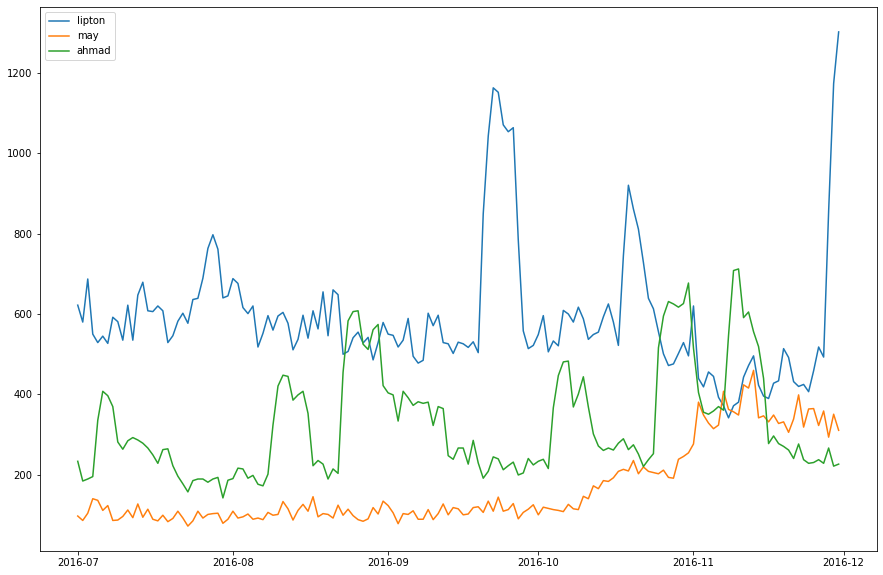

In [5]:
plt.figure(figsize=(15,10))
plt.plot(lipton.index, lipton.receipts_count, label='lipton')
plt.plot(may.index, may.receipts_count, label='may')
plt.plot(ahmad.index, ahmad.receipts_count, label='ahmad')
plt.legend()
plt.show()

In [6]:
data.index

DatetimeIndex(['2016-07-01', '2016-07-01', '2016-07-01', '2016-07-02',
               '2016-07-02', '2016-07-02', '2016-07-03', '2016-07-03',
               '2016-07-03', '2016-07-04',
               ...
               '2016-11-27', '2016-11-28', '2016-11-28', '2016-11-28',
               '2016-11-29', '2016-11-29', '2016-11-29', '2016-11-30',
               '2016-11-30', '2016-11-30'],
              dtype='datetime64[ns]', name='date', length=459, freq=None)

In [7]:
dates = data.index
date_list = []
for date in dates:
    if date not in date_list:
        date_list.append(date)
len(date_list)

153

### Data Scraping

In [8]:
# TV-show release dates over the period from 01.06.2016 to 30.11.2016 
url = 'https://www.1tv.ru/shows/chto-gde-kogda/vypuski?order=asc&from=2016-06-01&to=2016-11-30'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
release_date = soup.find_all('span', class_='normal-wrap')

release_date_list = []
for date in release_date:
    if date.text[3:] not in release_date_list:
        release_date_list.append(date.text[3:])
release_date_list    

['05.06.2016',
 '19.06.2016',
 '25.09.2016',
 '02.10.2016',
 '09.10.2016',
 '16.10.2016',
 '23.10.2016',
 '20.11.2016',
 '27.11.2016']

In [9]:
release_date_list
release_date_formated = []
for date in release_date_list:
    date_formated = datetime.datetime.strptime(date, '%d.%m.%Y')
    release_date_formated.append(date_formated.date())

In [10]:
ahmad.loc[release_date_formated[2:]]

,receipts_count
date,
2016-09-25,223
2016-10-02,239
2016-10-09,401
2016-10-16,262
2016-10-23,238
2016-11-20,262
2016-11-27,229


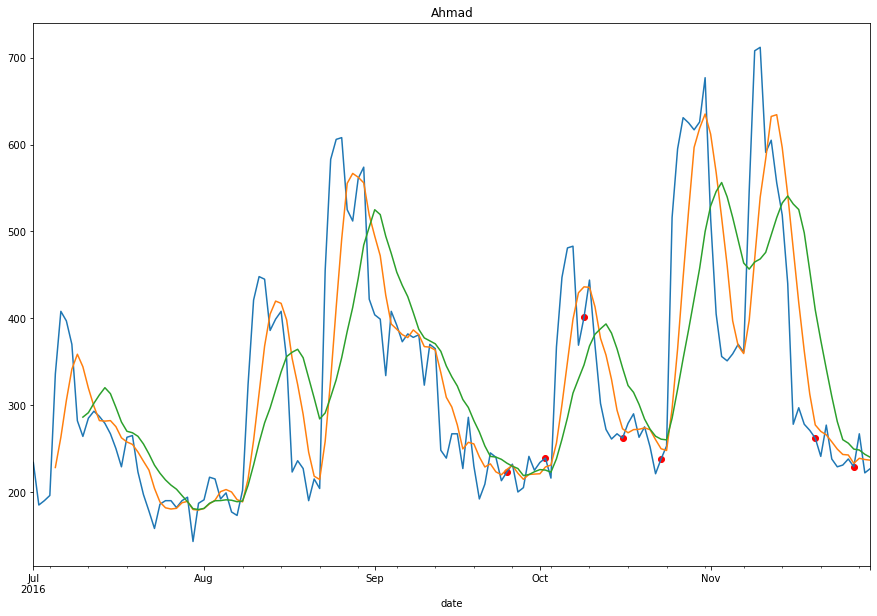

In [11]:
plt.figure(figsize=(15,10))
ahmad['receipts_count'].plot()
ahmad['receipts_count'].rolling(5).mean().plot(label='Moving average (window 5)')
ahmad['receipts_count'].rolling(10).mean().plot(label='Moving average (window 10)')
plt.scatter(ahmad.loc[release_date_formated[2:],'receipts_count'].dropna().index,
            ahmad.loc[release_date_formated[2:],'receipts_count'].dropna(), color='r')
plt.title('Ahmad')
plt.show()

## Stat approach

In [12]:
ahmad['efir1day'] = ahmad.index.isin(release_date_formated[2:]) # TV-show release date

iqr = np.percentile(ahmad['receipts_count'], 75) - np.percentile(ahmad['receipts_count'], 25)
lower_bound = np.percentile(ahmad['receipts_count'], 25) - 1.5 * iqr
upper_bound = np.percentile(ahmad['receipts_count'], 75) + 1.5 * iqr

ahmad['out_iqr'] = ahmad['receipts_count'].apply(lambda x: x < lower_bound or x > upper_bound)
ahmad.loc[release_date_formated[2:]]

,receipts_count,efir1day,out_iqr
date,,,
2016-09-25,223,True,False
2016-10-02,239,True,False
2016-10-09,401,True,False
2016-10-16,262,True,False
2016-10-23,238,True,False
2016-11-20,262,True,False
2016-11-27,229,True,False


In [13]:
ahmad[ahmad['out_iqr']==True] # Abnormal number of sales

,receipts_count,efir1day,out_iqr
date,,,
2016-10-31,677,False,True
2016-11-09,708,False,True
2016-11-10,712,False,True


In [14]:
# Number of days form the TV-show release date to the day with abnormally high number of sales

days_after = []
k = 0
for i in range(len(ahmad)):
    if ahmad.iloc[i]['efir1day'] == True:
        k = 0 
    else:
        k += 1
    days_after.append(k)

ahmad['days_after_release'] = days_after
ahmad[ahmad['out_iqr']==True]
        

,receipts_count,efir1day,out_iqr,days_after_release
date,,,,
2016-10-31,677,False,True,8
2016-11-09,708,False,True,17
2016-11-10,712,False,True,18


In [15]:
# Checking whether the abnormal number of sales is observed the day after the TV-show broadcast.
# New feature with shifted sales data up by one row
ahmad['out_iqr_next_day'] = ahmad['out_iqr']
ahmad['out_iqr_next_day'] = ahmad['out_iqr_next_day'].shift(periods=-1)

In [16]:
ahmad.loc[release_date_formated[2:]]

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day
date,,,,,
2016-09-25,223,True,False,0,False
2016-10-02,239,True,False,0,False
2016-10-09,401,True,False,0,False
2016-10-16,262,True,False,0,False
2016-10-23,238,True,False,0,False
2016-11-20,262,True,False,0,False
2016-11-27,229,True,False,0,False


In [17]:
# New features - moving averages with windows 5 and 10.
ahmad['mean_5'] = ahmad['receipts_count'].rolling(5).mean()
ahmad['mean_10'] = ahmad['receipts_count'].rolling(10).mean()
ahmad.loc[release_date_formated[2:]]

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day,mean_5,mean_10
date,,,,,,,
2016-09-25,223,True,False,0,False,226.0,233.2
2016-10-02,239,True,False,0,False,228.8,225.2
2016-10-09,401,True,False,0,False,436.2,346.2
2016-10-16,262,True,False,0,False,272.8,343.0
2016-10-23,238,True,False,0,False,249.8,260.8
2016-11-20,262,True,False,0,False,277.2,409.7
2016-11-27,229,True,False,0,False,233.0,249.4


In [18]:
iqr = np.percentile(ahmad['mean_5'], 75) - np.percentile(ahmad['mean_5'], 25)
lower_bound = np.percentile(ahmad['mean_5'], 25) - 1.5 * iqr
upper_bound = np.percentile(ahmad['mean_5'], 75) + 1.5 * iqr

ahmad['out_iqr_mean_5'] = ahmad['mean_5'].apply(lambda x: x < lower_bound or x > upper_bound)
ahmad['out_iqr_mean_5'] = ahmad['out_iqr_mean_5'].shift(periods=-5)


In [19]:
iqr = np.percentile(ahmad['mean_10'], 75) - np.percentile(ahmad['mean_10'], 25)
lower_bound = np.percentile(ahmad['mean_10'], 25) - 1.5 * iqr
upper_bound = np.percentile(ahmad['mean_10'], 75) + 1.5 * iqr

ahmad['out_iqr_mean_10'] = ahmad['mean_10'].apply(lambda x: x < lower_bound or x > upper_bound)
ahmad['out_iqr_mean_10'] = ahmad['out_iqr_mean_10'].shift(periods=-10)

In [20]:
ahmad.loc[release_date_formated[2:]]

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day,mean_5,mean_10,out_iqr_mean_5,out_iqr_mean_10
date,,,,,,,,,
2016-09-25,223,True,False,0,False,226.0,233.2,False,False
2016-10-02,239,True,False,0,False,228.8,225.2,False,False
2016-10-09,401,True,False,0,False,436.2,346.2,False,False
2016-10-16,262,True,False,0,False,272.8,343.0,False,False
2016-10-23,238,True,False,0,False,249.8,260.8,False,False
2016-11-20,262,True,False,0,False,277.2,409.7,False,False
2016-11-27,229,True,False,0,False,233.0,249.4,NaN,NaN


In [21]:
ahmad[ahmad['out_iqr_mean_5']==True]

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day,mean_5,mean_10,out_iqr_mean_5,out_iqr_mean_10
date,,,,,,,,,


In [22]:
ahmad[ahmad['out_iqr_mean_10']==True]

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day,mean_5,mean_10,out_iqr_mean_5,out_iqr_mean_10
date,,,,,,,,,


*There are no abnormal sales values among moving averages

C:\Users\ialsh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


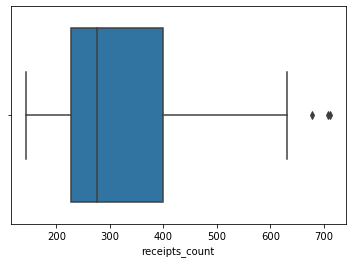

In [23]:
sns.boxplot(ahmad['receipts_count'])

*Boxplot shows abnormal values higher than 650, which is considerably higher than those after the TV-show broadcast.

C:\Users\ialsh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


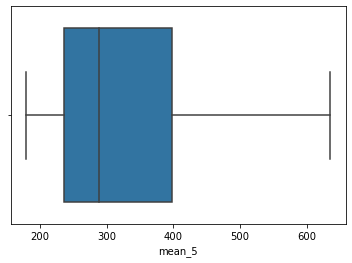

In [24]:
sns.boxplot(ahmad['mean_5'])

C:\Users\ialsh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


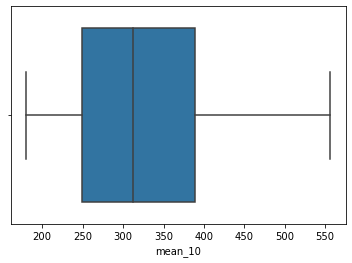

In [25]:
sns.boxplot(ahmad['mean_10'])

# Clustering sample

### Ahmad

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=30, min_samples=5)
ahmad['prediction_dbscan_1'] = dbscan.fit_predict(ahmad['receipts_count'].values.reshape(-1, 1))
ahmad.head()

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day,mean_5,mean_10,out_iqr_mean_5,out_iqr_mean_10,prediction_dbscan_1
date,,,,,,,,,,
2016-07-01,234,False,False,1,False,NaN,NaN,False,False,0
2016-07-02,185,False,False,2,False,NaN,NaN,False,False,0
2016-07-03,190,False,False,3,False,NaN,NaN,False,False,0
2016-07-04,196,False,False,4,False,NaN,NaN,False,False,0
2016-07-05,336,False,False,5,False,228.2,NaN,False,False,0


In [27]:
ahmad['prediction_dbscan_1'].value_counts()

 0    131
 1     19
-1      3
Name: prediction_dbscan_1, dtype: int64

Text(0.5, 1.0, 'Clusters determined by DBSCAN')

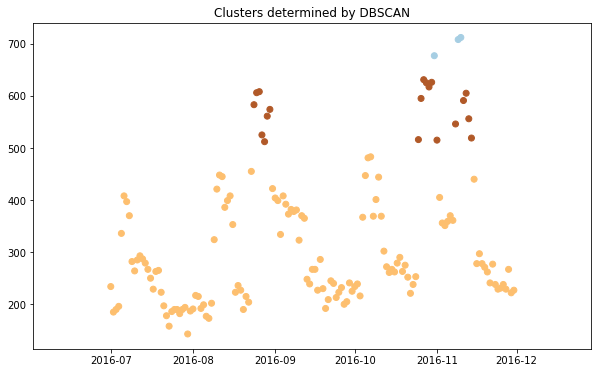

In [28]:
plt.figure(figsize=(10,6))
plt.scatter(ahmad.index, ahmad['receipts_count'], c=ahmad['prediction_dbscan_1'], cmap='Paired')
plt.title("Clusters determined by DBSCAN")

In [29]:
ahmad[ahmad['prediction_dbscan_1'] < 0]

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day,mean_5,mean_10,out_iqr_mean_5,out_iqr_mean_10,prediction_dbscan_1
date,,,,,,,,,,
2016-10-31,677,False,True,8,False,635.2,499.9,False,False,-1
2016-11-09,708,False,True,17,True,468.8,464.8,False,False,-1
2016-11-10,712,False,True,18,False,539.4,468.3,False,False,-1


*DBSCAN was able to isolate three cases, that were assigned as anomalies above.

### Lipton

In [30]:
lipton.head()

,receipts_count
date,
2016-07-01,622
2016-07-02,580
2016-07-03,687
2016-07-04,550
2016-07-05,529


C:\Users\ialsh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


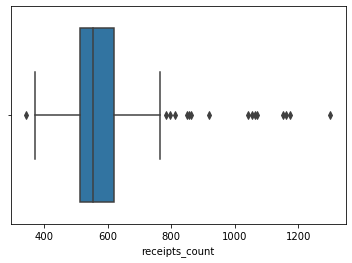

In [31]:
sns.boxplot(lipton['receipts_count'])

In [32]:
dbscan = DBSCAN(eps=30, min_samples=5)
lipton['prediction_dbscan_1'] = dbscan.fit_predict(lipton['receipts_count'].values.reshape(-1, 1))
lipton['prediction_dbscan_1'].value_counts()

 0    134
-1     14
 1      5
Name: prediction_dbscan_1, dtype: int64

Text(0.5, 1.0, 'Clusters determined by DBSCAN')

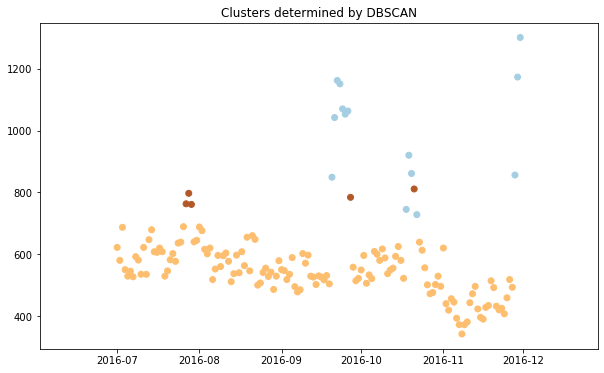

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(lipton.index, lipton['receipts_count'], c=lipton['prediction_dbscan_1'], cmap='Paired')
plt.title("Clusters determined by DBSCAN")

### May

In [34]:
may.head()

,receipts_count
date,
2016-07-01,98
2016-07-02,87
2016-07-03,105
2016-07-04,141
2016-07-05,137


C:\Users\ialsh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


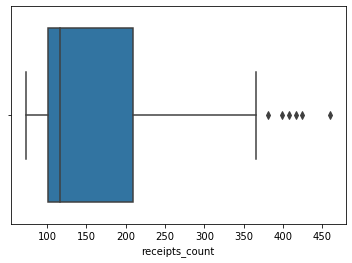

In [35]:
sns.boxplot(may['receipts_count'])

In [36]:
dbscan = DBSCAN(eps=30, min_samples=5)
may['prediction_dbscan_1'] = dbscan.fit_predict(may['receipts_count'].values.reshape(-1, 1))
may['prediction_dbscan_1'].value_counts()

 0    124
 1     28
-1      1
Name: prediction_dbscan_1, dtype: int64

Text(0.5, 1.0, 'Clusters determined by DBSCAN')

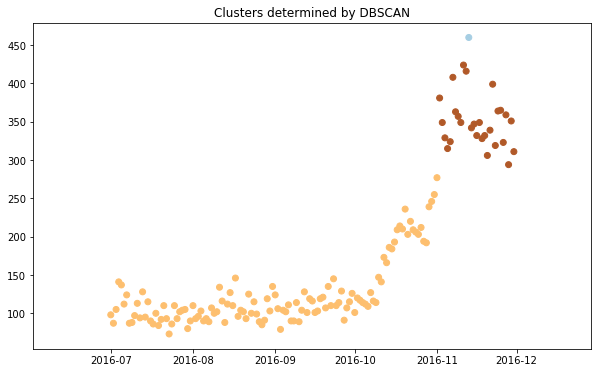

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(may.index, may['receipts_count'], c=may['prediction_dbscan_1'], cmap='Paired')
plt.title("Clusters determined by DBSCAN")

# Building a  predictive model

In [38]:
ahmad['res_box'], lmbda = stats.boxcox(ahmad.receipts_count)

In [39]:
ahmad.index

DatetimeIndex(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04',
               '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08',
               '2016-07-09', '2016-07-10',
               ...
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30'],
              dtype='datetime64[ns]', name='date', length=153, freq=None)

In [40]:
release_date_formated_ = []
for date in release_date_formated:
    release_date_formated_.append(np.datetime64(date))

In [42]:
firstpoint = ahmad.copy()
firstpoint['res_box'], lmbda = stats.boxcox(firstpoint['receipts_count'])
firstpoint

,receipts_count,efir1day,out_iqr,days_after_release,out_iqr_next_day,mean_5,mean_10,out_iqr_mean_5,out_iqr_mean_10,prediction_dbscan_1,res_box
date,,,,,,,,,,,
2016-07-01,234,False,False,1,False,NaN,NaN,False,False,0,1.470086
2016-07-02,185,False,False,2,False,NaN,NaN,False,False,0,1.463213
2016-07-03,190,False,False,3,False,NaN,NaN,False,False,0,1.464048
2016-07-04,196,False,False,4,False,NaN,NaN,False,False,0,1.465003
2016-07-05,336,False,False,5,False,228.2,NaN,False,False,0,1.478785
...,...,...,...,...,...,...,...,...,...,...,...
2016-11-26,238,False,False,6,False,242.6,256.2,NaN,NaN,0,1.470542
2016-11-27,229,True,False,0,False,233.0,249.4,NaN,NaN,0,1.469498
2016-11-28,267,False,False,1,False,238.8,248.3,NaN,NaN,0,1.473502


In [47]:
firstpoint['id'] = list(range(0, len(firstpoint)))

In [43]:
%%time
ps = arange(0, 5)
d=1
qs = arange(1, 4)
Ps = arange(1, 4)
D=1
Qs = arange(0, 2)
results = []
best_aic = float("inf")
for ps in range(0,5):
    for qs in range(1,4):
        for Ps in range(1,4):
            for Qs in range(0,2):
                try:
                    model=sm.tsa.statespace.SARIMAX(firstpoint.res_box, order=(ps, d, qs), 
                                                    seasonal_order=(Ps, D, Qs, 7)).fit(disp=-1)
                except Exception as ex:
                    print(ex)
                    continue
                aic = model.aic
                if aic < best_aic:
                    best_model = model
                    best_aic = aic
                results.append([[ps,qs,Ps,Qs], model.aic])

C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Us

C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Us

C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Us

C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\

C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Us

Schur decomposition solver error.


C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ialsh\

Wall time: 1min 55s


In [44]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             res_box   No. Observations:                  153
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 7)   Log Likelihood                 587.391
Date:                             Fri, 10 Dec 2021   AIC                          -1164.782
Time:                                     16:57:05   BIC                          -1149.898
Sample:                                 07-01-2016   HQIC                         -1158.734
                                      - 11-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0614      0.087      0.702      0.483      -0.110       0.233
ma.L2         -0.0799      

In [45]:
release_date_formated_

[numpy.datetime64('2016-06-05'),
 numpy.datetime64('2016-06-19'),
 numpy.datetime64('2016-09-25'),
 numpy.datetime64('2016-10-02'),
 numpy.datetime64('2016-10-09'),
 numpy.datetime64('2016-10-16'),
 numpy.datetime64('2016-10-23'),
 numpy.datetime64('2016-11-20'),
 numpy.datetime64('2016-11-27')]

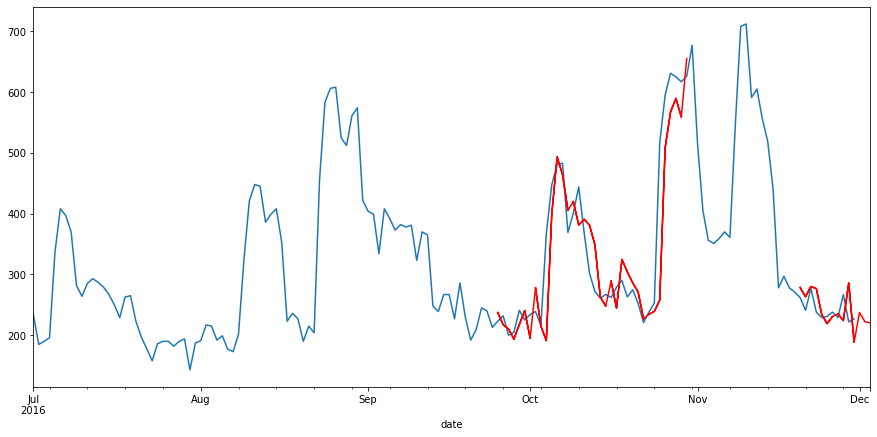

In [48]:
plt.figure(figsize(15,7))
firstpoint['receipts_count'].plot()

firstpoint_forecast = firstpoint[['receipts_count']]
for i in range(2, len(release_date_formated_)):
    date_list = [release_date_formated_[i] + np.timedelta64(x,'D') for x in range(0,7)]
    future = pd.DataFrame(index=date_list, columns= firstpoint_forecast.columns)
    firstpoint_forecast = pd.concat([firstpoint_forecast, future])
    first = firstpoint[firstpoint.index == release_date_formated_[i]]['id'][0]
    last = first + 7
    firstpoint_forecast['forecast'] = inv_boxcox(best_model.predict(start=first, end=last), lmbda)
    firstpoint_forecast['forecast'].plot(color='r')


Predicted values are close to true values.